* This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.
* The names and social security numbers of the patients were recently removed from the database, replaced with dummy values. One file has been "processed", that one containing the Cleveland database. All four unprocessed files also exist in this directory.

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Additional imports
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting/parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Feature processing
from sklearn.feature_selection import SelectPercentile, chi2

# Evaluation metrics
from sklearn.metrics import confusion_matrix


In [7]:
df = pd.read_csv(r'./heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Description of columns
* age: The person's age in years
* sex: The person's sex (1 = male, 0 = female)
* cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
* trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
* chol: The person's cholesterol measurement in mg/dl
* fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)*
* restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or  definite left ventricular hypertrophy by Estes' criteria)
* thalach: The person's maximum heart rate achieved
* exang: Exercise induced angina (1 = yes; 0 = no)
* oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
* slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
* ca: The number of major vessels (0-3)
* thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
* target: Heart disease (0 = no, 1 = yes)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [11]:
df.shape

(303, 14)

In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# data visulization

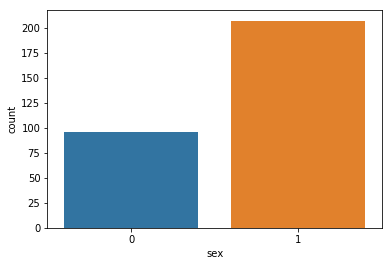

In [17]:
sns.countplot(df['sex']) # 1 - male 0-female

* based on this around 66% male are in dataset

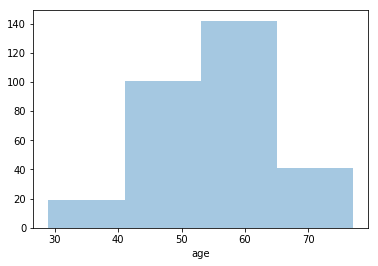

In [15]:
sns.distplot(df['age'],bins = 4, kde= False)

* around 80% population are in range 41-66 

In [22]:
total = len(df['sex'])
males = df['sex'].sum()
females = len(df['sex'])-males
print("Percentage of males:", round(males/total*100, 3))
print("percentage of females:", round(females/total*100, 3))
males,females

Percentage of males: 68.317
percentage of females: 31.683


(207, 96)

Text(0, 0.5, 'amount')

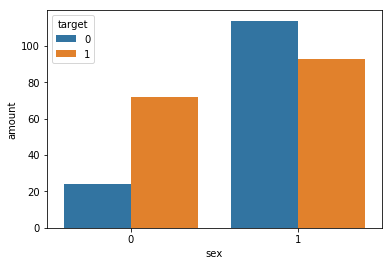

In [25]:
sex_graph = sns.countplot(df["sex"], hue=df["target"])
sex_graph.set_ylabel("amount")

* There are not a huge disparity between the number of healthy and unhealthy men. The difference is more notoriuos for females.(based on target columns)

Text(0, 0.5, 'amount')

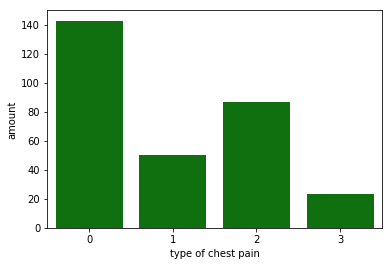

In [28]:
cp_graph = sns.countplot(df['cp'],color = 'green' ) 
cp_graph.set_xlabel('type of chest pain')
cp_graph.set_ylabel('amount')

* result shows that most of people having type 1 chest pain

In [29]:
corr = df.corr()

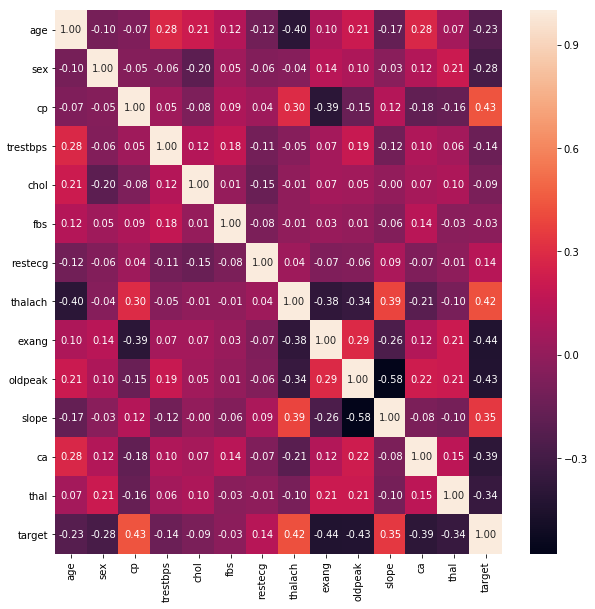

In [30]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt='.2f')

* A summary of the correlation of every pair of features. The ones that are more correlated with the target are **cp, thalach and slop** in that order. This is a good way to later select the most promising features for our final model, although there are other more sophisticated and automated ways to select the best features

### Due to the description of the features, some of them are categorical not numbers, so let's fix that.

In [32]:
df['sex'] = df['sex'].astype('object')
df['cp'] = df['cp'].astype('object')
df['fbs'] = df['fbs'].astype('object')
df['restecg'] = df['restecg'].astype('object')
df['exang'] = df['exang'].astype('object')
df['slope'] = df['slope'].astype('object')
df['thal'] = df['thal'].astype('object')

In [33]:
df.dtypes


age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca            int64
thal         object
target        int64
dtype: object

## now use get dummies

In [34]:
df = pd.get_dummies(df)
df.head()

,age,trestbps,chol,thalach,oldpeak,ca,target,sex_0,sex_1,cp_0,...,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0


In [35]:
df.shape

(303, 27)

# machine learning

* Let's try some models to see their performance. Due to the fact that is a small dataset, we are going to use cross_validation rather than the usual train_test_split. To evaluate our models we will use "recall".

We are using a health dataset and exist a high cost associated with False Negative (people with heart desease with the wrong diagnosis). That is the main number we want to minimize, and recall captures exactly what we want. This is the ecuation for recall:

Recall = True Positive / (True Positive + False Negative)

In [44]:
df.head()

,age,trestbps,chol,thalach,oldpeak,ca,target,sex_0,sex_1,cp_0,...,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0


In [48]:
# Getting features and target
X = df.drop(["target"], axis=1)
y = df["target"]

In [50]:
X.shape

(303, 26)

# RANDOM FOREST

In [56]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_predictions = cross_val_predict(rf_model, X, y, cv=5)
print(confusion_matrix(y, rf_predictions))
rf_scores = cross_val_score(rf_model, X, y, scoring="recall", cv=5)
print("recall:", rf_scores.mean())

[[109  29]
 [ 27 138]]
recall: 0.8545454545454545


# Support Vector Machine


In [58]:
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean())


[[  8 130]
 [  2 163]]
recall: 0.9878787878787879


# Logistic Regression

In [59]:
lr_model = LogisticRegression(solver="liblinear")
lr_predictions = cross_val_predict(lr_model, X, y, cv=5)
print(confusion_matrix(y, lr_predictions))
lr_scores = cross_val_score(lr_model, X, y, scoring="recall", cv=5)
print("recall:", lr_scores.mean())

[[106  32]
 [ 23 142]]
recall: 0.8606060606060606


# XGBoost ( popular model for kaggle competitions)

In [62]:
xgb_model = XGBClassifier()
xgb_predictions = cross_val_predict(xgb_model, X, y, cv=5)
print(confusion_matrix(y, xgb_predictions))
xgb_scores = cross_val_score(xgb_model, X, y, scoring="recall", cv=5)
print("recall:", xgb_scores.mean())

[[105  33]
 [ 28 137]]
recall: 0.8303030303030304


## so we used several machine learning model based on these svm model gives extraordinary output them we should go with SVM

# feature scaling

#### so in our data no outlier is present so we are going to use minmax scalar and also for SVM minmax scaling gives preety good o/p

In [64]:
X["age"] = X["age"].map(lambda x: (x - X["age"].min()) / (X["age"].max() - X["age"].min()))
X["trestbps"] = X["trestbps"].map(lambda x: (x - X["trestbps"].min()) / (X["trestbps"].max() - X["trestbps"].min()))
X["chol"] = X["chol"].map(lambda x: (x - X["chol"].min()) / (X["chol"].max() - X["chol"].min()))
X["thalach"] = X["thalach"].map(lambda x: (x - X["thalach"].min()) / (X["thalach"].max() - X["thalach"].min()))
X["oldpeak"] = X["oldpeak"].map(lambda x: (x - X["oldpeak"].min()) / (X["oldpeak"].max() - X["oldpeak"].min()))

In [65]:
# Support Vector Machine
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean())

[[105  33]
 [ 16 149]]
recall: 0.9030303030303031


* The recall now is lower, but applying feature scaling, the SVM is doing a better job classifying the people in general. It is a more robust classifier compared to the previous one

# Feature selection
**Currently, We are using all features available in the dataset, however:
features != information
More features not always lead to better performance, what we really want is the exact number of features that can capture the essence. Many times datasets come with lots of features but often times just small portion of them drives the performance of a model.
This time we are going to use SelectPercentile to get the exact porcentage of features that lead to the best performance on the evaluation metric.**

In [67]:
best_recall = 0
for n in range(1, 101):
    X_new = SelectPercentile(chi2, percentile=n).fit_transform(X, y)

    svc_model = SVC(gamma="auto")
    svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
    svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
    
    if svc_scores.mean() > best_recall:
        best_recall = svc_scores.mean()
        print(confusion_matrix(y, svc_predictions))
        print("the best percentage so far:", n)
        print("the best recall so far", svc_scores.mean(), "\n")

[[ 92  46]
 [ 34 131]]
the best percentage so far: 1
the best recall so far 0.793939393939394 

[[102  36]
 [ 19 146]]
the best percentage so far: 9
the best recall so far 0.884848484848485 

[[104  34]
 [ 17 148]]
the best percentage so far: 17
the best recall so far 0.8969696969696971 

[[109  29]
 [ 15 150]]
the best percentage so far: 21
the best recall so far 0.9090909090909092 

[[108  30]
 [ 14 151]]
the best percentage so far: 33
the best recall so far 0.9151515151515153 



In [68]:
X_new = SelectPercentile(chi2, percentile=33).fit_transform(X, y)        
svc_model = SVC(gamma="auto")
svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
print(confusion_matrix(y, svc_predictions))
svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
print("recall:", svc_scores.mean(), "\n")

print("Old number of features used:",X.shape[1])
print("New number of features used:",X_new.shape[1])

[[108  30]
 [ 14 151]]
recall: 0.9151515151515153 

Old number of features used: 26
New number of features used: 9


Using feature selection, we got rid of irrelevant features and now we are using just the ones that make our model better. Before we used 26 features, now we are using just 9 of them. Roughly 1/3 of them.

If you are curious about what are the features we are using run the cell below. They are, the nine that have the highest correlation with the targe

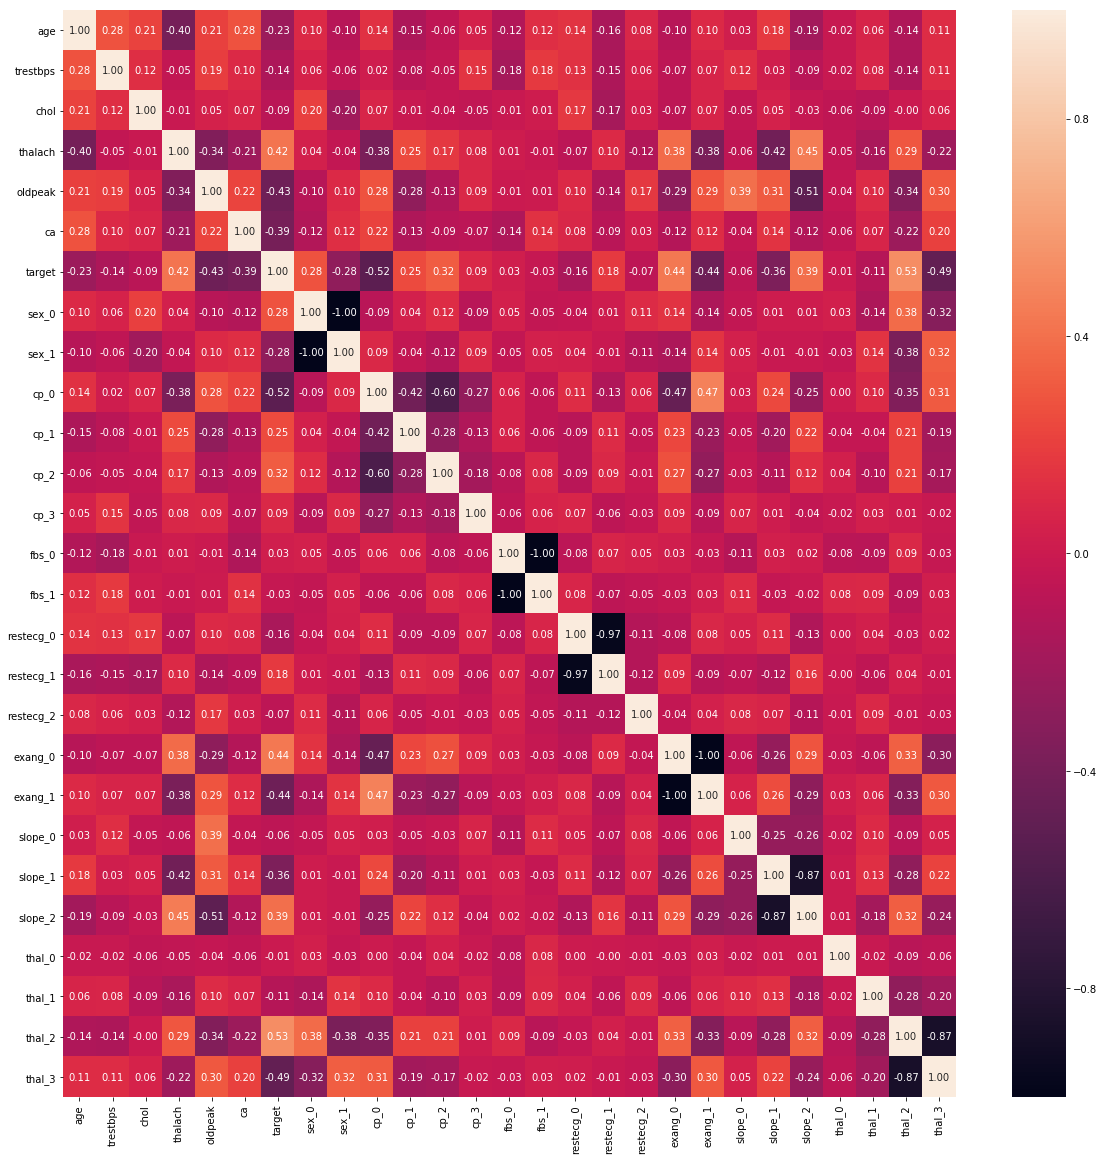

In [70]:
# EXPLORE FOR BETTER WAY TO KNOW BEST FEATURES AFTER FEATURE SELECTION

plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

## Cross validation for parameter tuning
Finally, we will explore many combinations of parameters using something called in sklearn GridSearchCV. This time we only will search for C and kernel parameters. And to be things more enjoyable we will code up by ourself. It is pretty easy!!!

In [71]:
Cs = [1, 10, 100, 1000]
kernels = ["linear", "rbf", "poly"]

for c in Cs:
    for k in kernels:
        
        print("C:", c)
        print("Kernel:", k)
        svc_model = SVC(gamma="auto", C=c, kernel=k)
        svc_predictions = cross_val_predict(svc_model, X_new, y, cv=5)
        print(confusion_matrix(y, svc_predictions))
        svc_scores = cross_val_score(svc_model, X_new, y, scoring="recall", cv=5)
        print("recall:", svc_scores.mean(), "\n")

C: 1
Kernel: linear
[[111  27]
 [ 24 141]]
recall: 0.8545454545454547 

C: 1
Kernel: rbf
[[108  30]
 [ 14 151]]
recall: 0.9151515151515153 

C: 1
Kernel: poly
[[ 86  52]
 [  8 157]]
recall: 0.9515151515151515 

C: 10
Kernel: linear
[[106  32]
 [ 20 145]]
recall: 0.8787878787878789 

C: 10
Kernel: rbf
[[109  29]
 [ 24 141]]
recall: 0.8545454545454547 

C: 10
Kernel: poly
[[108  30]
 [ 17 148]]
recall: 0.8969696969696971 

C: 100
Kernel: linear
[[107  31]
 [ 22 143]]
recall: 0.8666666666666668 

C: 100
Kernel: rbf
[[108  30]
 [ 25 140]]
recall: 0.8484848484848484 

C: 100
Kernel: poly
[[107  31]
 [ 20 145]]
recall: 0.8787878787878789 

C: 1000
Kernel: linear
[[108  30]
 [ 22 143]]
recall: 0.8666666666666668 

C: 1000
Kernel: rbf
[[112  26]
 [ 27 138]]
recall: 0.8363636363636363 

C: 1000
Kernel: poly
[[105  33]
 [ 27 138]]
recall: 0.8363636363636363 



**These two are the best results:
The default configuration (C=1 and kernel="rbf"), having a recall of 0.915
Using C=1 and kernel="poly", having a recall of 0.951
Apparently what the model does if we change the kernel parameter to "poly" is to misclassify 22 true negatives to 22 false positives. In other words, 22 people that are healthy are classified as sick. And correctly classify 6 more true positives previously misclassified as 6 false negatives. In other words, 6 more people are correctly classified as sick.
So, what is a better model?
I personally think that the second one is better for this task and this is why:
As I mentioned before in a previous cell false negatives have a highest cost as a whole compared to false positives.**
